# Estimate SNPs contributing the most to PRS
- **Project:** Multi-ancestry PRS
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Last Updated:** 14-APRIL-2024

## Notebook Overview
- Identifying key SNPs driving PRS prediction

In [35]:
## Import the necessary packages 
import os
import numpy as np
import pandas as pd
import math
import sys
import subprocess
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numbers

## Print out package versions
## Getting packages loaded into this notebook and their versions to allow for reproducibility
    # Repurposed code from stackoverflow here: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

## Import packages 
import pkg_resources
import types
from datetime import date
today = date.today()
date = today.strftime("%d-%b-%Y").upper()

## Define function 
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

## Get a list of packages imported 
imports = list(set(get_imports()))

# The only way I found to get the version of the root package from only the name of the package is to cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Print out packages and versions 
print(f"PACKAGE VERSIONS ({date})")
for r in requirements:
    print("\t{}=={}".format(*r))

PACKAGE VERSIONS (16-APR-2024)
	matplotlib==3.7.2
	numpy==1.24.4
	pandas==2.0.3
	scikit-learn==1.3.0
	scipy==1.11.1
	seaborn==0.12.2
	statsmodels==0.14.0


In [36]:
## Make a function to convert model to dataframe of values to print out 
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    stderr = results.bse
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"PVAL":pvals,
                               "BETA":coeff,
                               "STDERR":stderr
                               # "CONF_LOWER":conf_lower,
                               # "CONF_HIGHER":conf_higher
                                })

    # Calculate the odds ratios and the CIs 
    results_df['OR'] = results_df['BETA'].apply(np.exp)
    results_df['OR-95LOWERCI'] = results_df['OR'] - 1.96 * results_df['STDERR']
    results_df['OR-95UPPERCI'] = results_df['OR'] + 1.96 * results_df['STDERR']
    
    # Reordering...
    results_df = results_df[["PVAL","BETA", "STDERR", "OR", "OR-95LOWERCI", "OR-95UPPERCI"]].sort_values(by = 'PVAL')
    return results_df

############# EAS #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/EAS/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/EAS/EAS-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/EAS/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/EAS/EAS-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/EAS/EAS-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/EAS/EAS-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

In [40]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENOTYPE']==1, "CONTROL", "PD")
merged_df2['sex_for_qc'] = np.where(merged_df2['sex_for_qc']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')
snp_beta_df.to_csv(f"{WORK_DIR}/imputed_data/EAS/EAS_BestSNPs.csv",sep='\t')

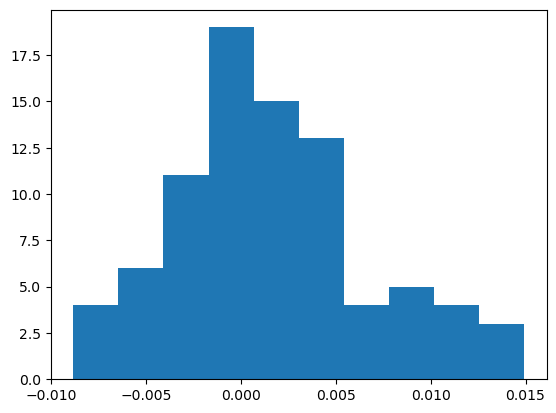

In [41]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()

############# AFR #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/AFR/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/AFR/AFR-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/AFR/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/AFR/AFR-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AFR/AFR-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AFR/AFR-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

In [73]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENOTYPE']==1, "CONTROL", "PD")
merged_df2['sex_for_qc'] = np.where(merged_df2['sex_for_qc']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')
snp_beta_df.to_csv(f"{WORK_DIR}/imputed_data/AFR/AFR_BestSNPs.csv",sep='\t')

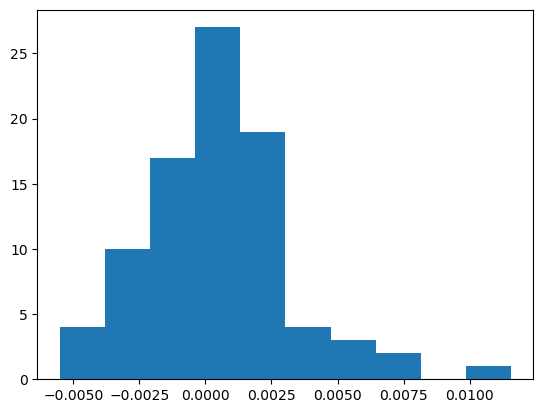

In [74]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()

############# AAC #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/AAC/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/AAC/AAC-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/AAC/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/AAC/AAC-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AAC/AAC-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AAC/AAC-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

In [78]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENOTYPE']==1, "CONTROL", "PD")
merged_df2['sex_for_qc'] = np.where(merged_df2['sex_for_qc']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')
snp_beta_df.to_csv(f"{WORK_DIR}/imputed_data/AAC/AAC_BestSNPs.csv",sep='\t')

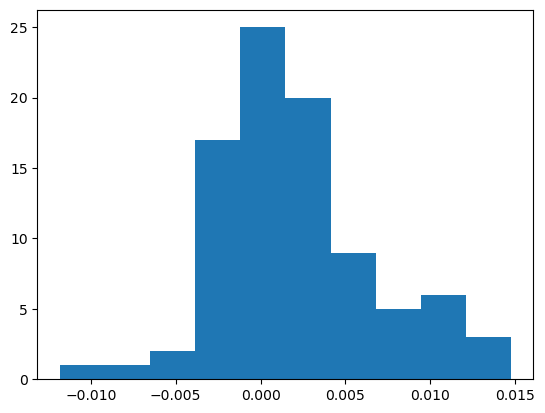

In [79]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()

############# AJ #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/AJ/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/AJ/AJ-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/AJ/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/AJ/AJ-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AJ/AJ-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AJ/AJ-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

In [83]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENOTYPE']==1, "CONTROL", "PD")
merged_df2['sex_for_qc'] = np.where(merged_df2['sex_for_qc']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')
snp_beta_df.to_csv(f"{WORK_DIR}/imputed_data/AJ/AJ_BestSNPs.csv",sep='\t')

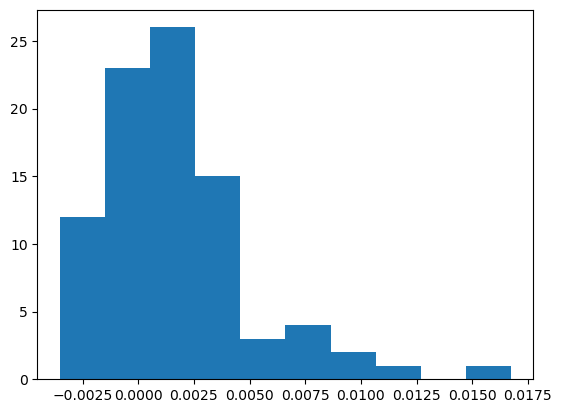

,SNP,A1,BETA,CONTROL,PD,FREQ_DIFFERENCE,EFFECT_MEAN
1:155235843_T,1:155235843,T,-0.7467,1.938998,1.722222,-0.216776,0.161866
4:958159_T,4:958159,T,-0.2126,1.426667,1.315939,-0.110728,0.023541
12:40340400_A,12:40340400,A,2.4289,0.023965,0.318694,0.294729,0.715866


In [84]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()
snp_beta_df[snp_beta_df.EFFECT_MEAN>0.02]

############# AMR #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/AMR/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/AMR/AMR-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/AMR/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/AMR/AMR-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AMR/AMR-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/AMR/AMR-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

In [88]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENOTYPE']==1, "CONTROL", "PD")
merged_df2['sex_for_qc'] = np.where(merged_df2['sex_for_qc']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')
snp_beta_df.to_csv(f"{WORK_DIR}/imputed_data/AMR/AMR_BestSNPs.csv",sep='\t')

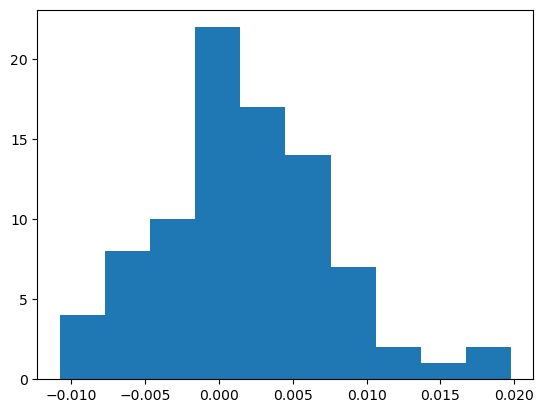

In [89]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()

############# EUR #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/EUR/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/projects/PRS_multi_ancestry_Nov2023/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/EUR/EUR-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/EUR/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/EUR/EUR-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/EUR/EUR-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/EUR/EUR-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

In [ ]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENOTYPE']==1, "CONTROL", "PD")
merged_df2['sex_for_qc'] = np.where(merged_df2['sex_for_qc']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')
snp_beta_df.to_csv(f"{WORK_DIR}/imputed_data/EUR/AMR_BestSNPs.csv",sep='\t')

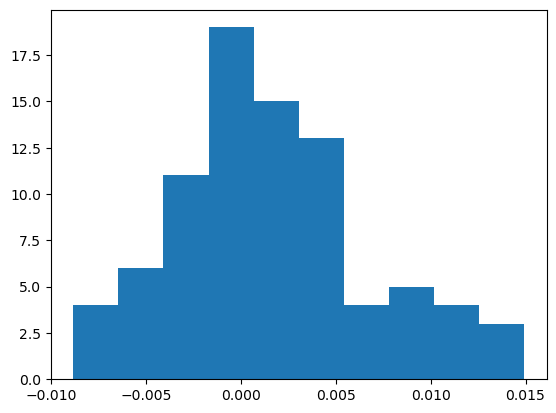

In [63]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()

############# CAS #############

In [ ]:
%%bash

module load plink/2.0-alpha

plink2 \
--bfile ${WORK_DIR}/imputed_data/CAS/PRS_ALL_release6_gender \
--rm-dup force-first \
--score ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
--out ${WORK_DIR}/imputed_data/CAS/CAS-EUR90LOCI

In [ ]:
%%bash 

module load plink/2.0-alpha

# Create transposed data with dosages

plink2 \
--bfile ${WORK_DIR}/imputed_data/CAS/PRS_ALL_release6_gender \
--rm-dup force-first \
--extract ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--export A --export-allele ${WORK_DIR}/90LOCI_EUROPEANS_CHR_POS.txt \
--out ${WORK_DIR}/imputed_data/CAS/CAS-EUR90LOCI-transpose

In [ ]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/imputed_data/CAS/CAS-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
temp = pd.read_csv(f"{WORK_DIR}/covariates.txt", sep="\t")
cov_df = temp.rename(columns={'GP2sampleID': 'IID'})
transpose_df = pd.read_csv(f"{WORK_DIR}/imputed_data/CAS/CAS-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
merged_df2.head()

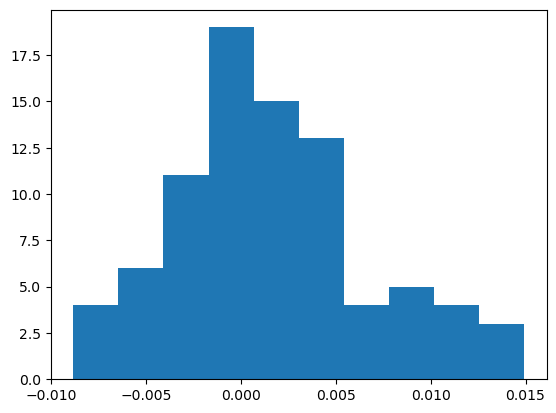

In [67]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()